Support Vector Machine (SVM) for Churn Prediction

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score,recall_score,classification_report,accuracy_score,confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
import pickle

To build and evaluate our SVM model for churn prediction, we begin by importing all the necessary Python libraries. This includes:

Pandas & NumPy for data handling and numerical operations

Matplotlib & Seaborn for visualization

Scikit-learn modules for splitting data, preprocessing, training the model, tuning hyperparameters, and evaluating performance

SVC for building the Support Vector Machine classifier. 

In [2]:
# load the data 
df = pd.read_csv('telecom_net_churn.csv')
df.head()

,Unnamed: 0,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,0,0,29,29,0,1,0,0,1,1,...,0,0,1,0,1,0,0,0,0,0
1,1,0,56,1889,0,0,1,1,0,1,...,0,0,0,1,0,0,1,0,0,0
2,2,0,53,108,1,0,1,1,0,1,...,0,0,0,1,1,0,0,0,0,0
3,3,0,42,1840,0,0,1,1,0,1,...,1,0,0,0,0,0,0,1,0,0
4,4,0,70,151,1,1,0,1,0,1,...,0,0,1,0,1,0,0,0,0,0


In [3]:
df = df.drop('Unnamed: 0',axis= 1)
df.head()

,SeniorCitizen,MonthlyCharges,TotalCharges,Churn_Values,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Tenure_Grouped_1 - 12,Tenure_Grouped_13 - 24,Tenure_Grouped_25 - 36,Tenure_Grouped_37 - 48,Tenure_Grouped_49 - 60,Tenure_Grouped_61 - 72
0,0,29,29,0,1,0,0,1,1,0,...,0,0,1,0,1,0,0,0,0,0
1,0,56,1889,0,0,1,1,0,1,0,...,0,0,0,1,0,0,1,0,0,0
2,0,53,108,1,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,0
3,0,42,1840,0,0,1,1,0,1,0,...,1,0,0,0,0,0,0,1,0,0
4,0,70,151,1,1,0,1,0,1,0,...,0,0,1,0,1,0,0,0,0,0


Before splitting the features and target, we removed the 'Unnamed: 0' column, which was likely an index column from CSV export and holds no predictive value

In [4]:
x = df.drop('Churn_Values',axis = 1)
y = df['Churn_Values']

Next, we separated the dataset into:

x: Feature variables used for prediction (all columns except 'Churn_Values')

y: Target variable indicating whether the customer churned (1) or not (0)

In [5]:
# train / validate / test split 

#15 percent testing data 

x_temp,x_test,y_temp,y_test = train_test_split(x,y ,test_size=0.15,random_state=42)

# 20 percent validating data

x_train,x_val,y_train,y_val = train_test_split(x_temp,y_temp,test_size=0.2,random_state= 42)

To ensure a robust model evaluation, the dataset was divided into three parts:

- 15% Test Set: Held out for final model evaluation after training.

- 20% Validation Set (from the remaining 85%): Used to tune the model during training.



In [6]:
baseline_svm = SVC(random_state=42)
baseline_svm.fit(x_train,y_train)

cv_auc_baseline_svm = cross_val_score(baseline_svm,x_train,y_train,cv = 5,scoring = 'roc_auc')
print('Cross Validation Auc - ',cv_auc_baseline_svm.mean())

Cross Validation Auc -  0.7862629046402799


Before applying SMOTE or tuning the model, we trained a SVM classifier on the original imbalanced dataset. Using 5-fold cross-validation with ROC AUC as the evaluation metric, the model achieved an average AUC score of 0.786.


In [7]:
scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
x_val_scaled = scaler.transform(x_val)

Before training the Support Vector Machine (SVM) model, we scaled the input features using StandardScaler, which standardizes data to have a mean of 0 and a standard deviation of 1. This step is crucial for SVM as it relies on distance-based calculations, and unscaled data can bias the model.

In [8]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'], 
    'gamma': ['scale', 'auto']
}


grid = GridSearchCV(
    estimator=SVC(probability=True, random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

To optimize the performance of our Support Vector Machine (SVM) model, we used GridSearchCV to search over a range of key hyperparameters. This process performs an exhaustive search using 5-fold cross-validation and evaluates models based on the ROC AUC score, which is well-suited for imbalanced classification tasks like churn prediction

In [9]:
# Fit on training data
grid.fit(x_train_scaled,y_train)
print('Best CV ROC AUC',grid.best_score_)

Best CV ROC AUC 0.8226761376804644


After setting up the SVM model and defining the hyperparameter grid, we trained the model using 5-fold cross-validation on the scaled training data. The model was evaluated using the ROC AUC score, which reflects its ability to distinguish between churn and non-churn cases.

This score indicates that the tuned SVM model demonstrates strong discriminatory power on the training folds and is likely to generalize well on new data

In [10]:
best_model = grid.best_estimator_
best_model

SVC(C=0.1, kernel='linear', probability=True, random_state=42)

This best_model is now optimized with the best combination of hyperparameters (C, kernel, and gamma) and ready for validation and test evaluation.

In [11]:
# vaidation testing 

val_pred = best_model.predict(x_val_scaled)
val_prob = best_model.predict_proba(x_val_scaled)[:,1]

print('Validation Accuracy',best_model.score(x_val_scaled,y_val))
print('Validation ROC AUC SCORE :', roc_auc_score(y_val,val_prob))
print('Validation Recall Score :',recall_score(y_val,val_pred))
print('Validation Classification Report :\n',classification_report(y_val,val_pred))

Validation Accuracy 0.8177257525083612
Validation ROC AUC SCORE : 0.8599837662337662
Validation Recall Score : 0.5032467532467533
Validation Classification Report :
               precision    recall  f1-score   support

           0       0.84      0.93      0.88       888
           1       0.70      0.50      0.59       308

    accuracy                           0.82      1196
   macro avg       0.77      0.72      0.74      1196
weighted avg       0.81      0.82      0.81      1196



After training the Support Vector Machine (SVM) model with the best hyperparameters from GridSearchCV, we evaluated its performance on the validation set.

Accuracy: 81.77%
The model correctly predicted about 82% of the validation cases, indicating strong general performance.

ROC AUC Score: 0.860
A high AUC score shows that the model is quite good at distinguishing between churners and non-churners.

Recall (Churners - Class 1): 50.3%
The model was able to identify roughly half of all actual churners, but there's room for improvement in capturing more at-risk customers.

Precision (Churners - Class 1): 70%
Out of all the customers predicted to churn, 70% actually did — this shows a reasonable false-positive control.

F1-Score (Churners): 0.59
This balanced score suggests the model is performing moderately well in handling the trade-off between precision and recall.

Class 0 (Non-Churners):
The model performed very well in predicting customers who are not likely to churn, with a recall of 93% and a precision of 84%.

Overall, the SVM model shows strong overall accuracy and excellent performance for non-churners, while achieving decent recall and precision for churners — making it a balanced option for churn prediction tasks.

In [12]:
# Test Evaluation 

test_pred = best_model.predict(x_test_scaled)
test_prob = best_model.predict_proba(x_test_scaled)[:,1]

print('Test Accuracy :', best_model.score(x_test_scaled,y_test))
print('Test ROC AUC SCORE', roc_auc_score(y_test,test_prob))
print('Test RECALL SCORE :',recall_score(y_test,test_pred))
print('TEST Classification Report : \n',classification_report(y_test,test_pred))


Test Accuracy : 0.7867298578199052
Test ROC AUC SCORE 0.806950000913392
Test RECALL SCORE : 0.4471830985915493
TEST Classification Report : 
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       771
           1       0.65      0.45      0.53       284

    accuracy                           0.79      1055
   macro avg       0.73      0.68      0.70      1055
weighted avg       0.77      0.79      0.77      1055



The SVM model was evaluated on the unseen test data to assess its generalization performance. The results are as follows:

Accuracy: 78.67%
The model correctly predicted nearly 79% of all test cases, demonstrating good overall reliability.

ROC AUC Score: 0.807
A solid AUC score indicates the model is effective at ranking churners higher than non-churners across various thresholds.

Recall (Churners - Class 1): 44.7%
The model identified about 45% of actual churners, which is somewhat low — meaning many churners were missed.

Precision (Churners - Class 1): 65%
When the model predicted churn, it was right 65% of the time, suggesting decent confidence in its positive predictions.

F1-Score (Churners): 0.53
This reflects a moderate balance between recall and precision for churn detection.

Performance on Non-Churners (Class 0):
The model performed very well in identifying non-churners, with 91% recall and 82% precision — indicating it’s more conservative and accurate in predicting customers likely to stay

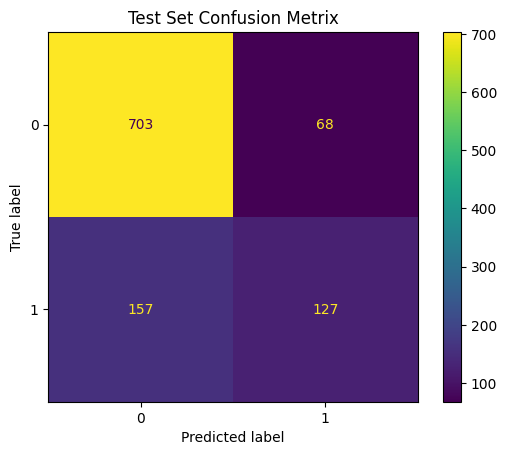

In [13]:
# plot confuion matrix and roc curve

ConfusionMatrixDisplay.from_estimator(best_model,x_test_scaled,y_test)
plt.title('Test Set Confusion Metrix')
plt.show()

The confusion matrix gives a detailed breakdown of the SVM model's performance on the test set:

True Negatives (TN) = 703
These are the customers who did not churn, and the model correctly predicted them as non-churners.

False Positives (FP) = 68
These customers did not churn, but the model incorrectly predicted they would — a false alarm.

False Negatives (FN) = 157
These customers actually did churn, but the model missed them, predicting they wouldn’t. This is a critical area of concern in churn prediction.

True Positives (TP) = 127
These are the churners the model correctly identified.

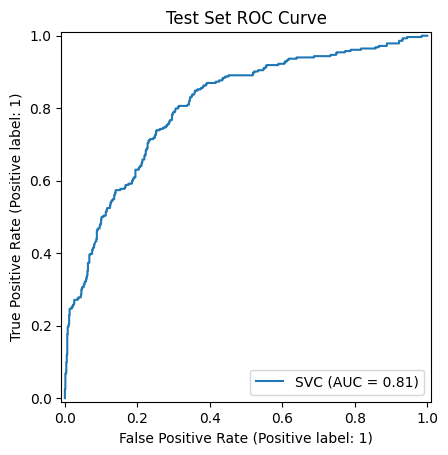

In [14]:
RocCurveDisplay.from_estimator(best_model,x_test_scaled,y_test)
plt.title('Test Set ROC Curve')
plt.show()

The ROC curve for the SVM model shows an AUC of 0.81, indicating good overall performance in distinguishing churners from non-churners. The model balances sensitivity and specificity well, making it a strong candidate for identifying churn risk.

Saving Model

In [15]:
# saving the model 

with open('svm_model.pkl','wb') as rf_file:
    pickle.dump(best_model,rf_file)

# saving the scaler 

with open('scaler.pkl','wb') as scaler_file:
    pickle.dump(scaler,scaler_file)    

In [16]:
#load model file 

with open('svm_model.pkl','rb') as rf_file:
    svm_model_loaded = pickle.load(rf_file)

# load scaler file 


with open('scaler.pkl','rb') as scaler_file:
    scaler_loaded = pickle.load(scaler_file)

In [17]:
# sample testing of model 

sample_data = pd.read_csv('telecom_net_churn.csv')

#prepare dataset for features and targets

features = sample_data.drop(columns=['Unnamed: 0','Churn_Values'])
targets = sample_data['Churn_Values']

#scale using the loaded scaler

features_scaled = scaler_loaded.transform(features)

# predict with loaded model

predicated_values = svm_model_loaded.predict(features_scaled)

# compare predicitions with actual churn 

print('classification_report : \n' , classification_report(targets,predicated_values))
print('confusion matrix : \n' , confusion_matrix(targets,predicated_values))

classification_report : 
               precision    recall  f1-score   support

           0       0.82      0.92      0.87      5163
           1       0.67      0.46      0.55      1869

    accuracy                           0.80      7032
   macro avg       0.75      0.69      0.71      7032
weighted avg       0.78      0.80      0.78      7032

confusion matrix : 
 [[4748  415]
 [1009  860]]


To evaluate how the saved SVM model performs on the full dataset, we loaded the original data, applied the saved scaler for preprocessing, and generated predictions.

Classification Report:

Accuracy: 80% of the predictions matched the actual churn values.

Class 0 (Non-Churn): Precision of 0.82 and recall of 0.92, indicating the model is very strong at correctly identifying customers who are likely to stay.

Class 1 (Churn): Precision of 0.67 and recall of 0.46, meaning the model struggles a bit more to detect actual churners, missing over half of them.

F1-score for Churn: 0.55, reflecting a moderate balance between precision and recall for the positive class.

Confusion Matrix Insights:

True Negatives (4748): Correctly identified non-churners.

False Positives (415): Non-churners incorrectly predicted as churners.

False Negatives (1009): Churners missed by the model.

True Positives (860): Correctly identified churners.

Overall, the model performs well for non-churn predictions but still leaves room for improvement in identifying actual churners.